In [54]:
import torch
import numpy as np
import deriv as der
import matplotlib.pyplot as plt

dtype = torch.float           
device = torch.device("cpu")

<ErrorbarContainer object of 3 artists>

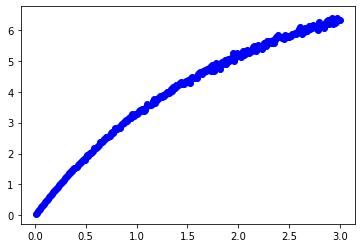

In [43]:
import scipy.integrate as integ

def Hub_the(z,om,H0):
    return H0*np.sqrt(om*pow(1+z,3)+1-om)

def normalized_hubble(z,args):
        om0 = args[1]
        omm = om0*pow(1.+z,3)
        ol0 = 1 - om0 

        return pow(omm + ol0 ,0.5)


def Ez_inv(z,args):
        return 1./normalized_hubble(z,args)


def com_dis(z,args):
        res = np.zeros(len(z))
        H0 = args[0]
        for i in range(len(z)):
            res[i] = integ.quad(Ez_inv, 0., z[i], args=args)[0]
        
        return (3e5/H0)*res   


sig = 0.01
n_obs = 300
eps = np.random.normal(0.,sig,n_obs)
z_obs = np.linspace(0.01,3,n_obs)
D_obs = com_dis(z_obs,[70,0.3])*(1+eps)
dD_obs = com_dis(z_obs,[70,0.3])*sig

data = np.c_[z_obs,D_obs/1000,dD_obs/1000]
plt.errorbar(z_obs,D_obs/1000,yerr=dD_obs/1000,fmt="bo")

In [44]:
Activation = torch.nn.SiLU()    #torch.nn.SELU(),#torch.nn.GELU(),#torch.nn.Tanh(),
    
model = torch.nn.Sequential(
    torch.nn.Linear(1, 10),
    Activation,
    torch.nn.Linear(10,10),
    Activation,
    torch.nn.Linear(10,5),
    Activation,
    torch.nn.Linear(5,1),
    torch.nn.Flatten(0, 1)
)


def der_act(x):
    t1 = 1 + torch.exp(-x) + x*torch.exp(-x)
    t2 = (1 + torch.exp(-x)).pow(2)
    return t1/t2

y = torch.from_numpy(data[:,1]).float()
err = torch.from_numpy(data[:,2]).float()

def loss_fn(y_pred,y):
    
    return ((y_pred - y)/err).pow(2).sum()


In [45]:
learning_rate = 1e-3
x = torch.from_numpy(data[:,0]).float()
x = torch.reshape(x,(len(data[:,0]),1))


optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
for t in range(50001):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x)

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    if t % 5000 == 0:
        print(t, loss.item())

    optimizer.zero_grad()

    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

0 3138413.75
5000 1782.3460693359375
10000 1162.495849609375
15000 839.1149291992188
20000 650.7496337890625
25000 597.2265014648438
30000 559.0806884765625
35000 562.5556640625
40000 514.8496704101562
45000 502.33447265625
50000 482.9219970703125


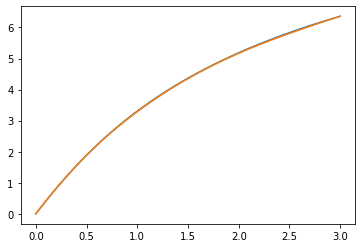

In [48]:
x_test = torch.linspace(0, 3, 2000, device=device, dtype=dtype)
x_test = torch.reshape(x_test,(2000,1))
y_th = com_dis(x_test,[70,0.3])
y_obs = com_dis(data[:,0],[70,0.3])
y_test = model(x_test)


plt.plot(x_test,y_th/1000)
plt.plot(x_test.detach().numpy().reshape(-1,),y_test.detach().numpy())
#plt.errorbar(data[:,0],data[:,1],yerr=data[:,2],fmt="bo")

71517.07748588234 tensor([71517.2344], grad_fn=<MulBackward0>)


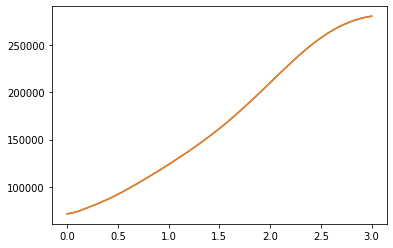

In [55]:
x = x_test[:,0].detach().numpy()
y = y_test.detach().numpy()

deriv = der.der_fun(model,x_test,der_act,4) 
der_num = np.gradient(y,x[1]-x[0])
print(3e5/der_num[10],3e5/deriv[10])

 
plt.plot(x,3e5/der_num)
plt.plot(x,3e5/deriv[:,0].detach().numpy())